In [155]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd                  #data processing e.g. reading files (pd.read_csv)
import numpy as np                   #linear algebra
import matplotlib.pyplot as plt      #plotting and visualization
import seaborn as sns                #visualization
import nltk
from nltk.corpus import stopwords
import requests
import warnings
import re 
from textblob import TextBlob 
from collections import Counter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.figsize'] = 8,4
from math import * 
import math
from sklearn.cluster import KMeans
import collections
from mlxtend.preprocessing import minmax_scaling


%matplotlib inline

# Yelp Web Scraping

In this section, we are using Beautifulsoup to scrape yelp review data from various restaurants in the NYC area. 

In [9]:
html1 = urlopen("https://www.yelp.com/search?find_desc=Restraunts%20&find_loc=nyc")
bsObj1 = BeautifulSoup(html1)

In [10]:
# Reviews
urls = []
c = 120
for i in range(12): 
    new = "https://www.yelp.com/biz/eleven-madison-park-new-york?start="+str(c)+"&sort_by=date_desc"
    urls.append(new)
    c+=20
Reviews_mad = []
for url in urls:
    html = urlopen(url)
    bsObj4 = BeautifulSoup(html)
   
    reviewers = bsObj4.find_all('div', {'itemprop': 'review'})
    for name in reviewers:
        Reviews_mad.append(name.get_text())

In [11]:
date_mad = []
Ratings_mad = []
for url in urls:
    html = urlopen(url)
    bsObj4 = BeautifulSoup(html)
    for name in bsObj4.find_all('meta', {'itemprop': 'datePublished'}):
        date_mad.append(name.get("content"))
    for reviewBody in bsObj4.findAll('div',{"class":"review-content"}):
        Ratings_mad.append(reviewBody.div.div.div.get("title"))


In [12]:
print(len(Ratings_mad))

240


In [13]:
print(len(Reviews_mad))

240


In [14]:
print(len(date_mad))

240


We put the scraped data into a pandas dataframe, as well as clean up the data collected. 

In [15]:
yelp_data = pd.DataFrame({'Review': Reviews_mad,'Rating':Ratings_mad, 'Date': date_mad})

Data clean-up: remove \n resulting from scraping of reviews. Ratings are strings, clean up ratings and cast into float. Date are strings, cast into datetime objects.

In [16]:
yelp_data['Review'] = [i.replace('\n', '') for i in yelp_data['Review']]
yelp_data['Rating'] = [float(re.sub(r'[^\d.]+','', i)) for i in yelp_data['Rating']]
yelp_data["Date"] = [pd.to_datetime(i) for i in yelp_data["Date"]]

We then also put the dataset into a csv file.

In [17]:
yelp_data.to_csv("yelp_data.csv")

# Review Sentiment Analysis

Our first sentiment analysis is done through the built in package TextBlob, which allows to extract a polarity between -1 to 1 of the review. We add that as a column in the dataframe.

In [18]:
#sentiment analysis 
def review_sentiment(review): 
    analysis = TextBlob(review) 
    return analysis.sentiment.polarity

In [19]:
sentiment_list = []
for review in yelp_data['Review']:
    sentiment_list.append(review_sentiment(review))
for sent in sentiment_list:
    yelp_data["Sentiment"] = [i for i in sentiment_list]


In [20]:
yelp_data.head(5)

,Review,Rating,Date,Sentiment
0,If second time is the charm then our dinner on...,4.0,2018-11-15,0.337662
1,"Very good. But I guess with all the hype, I w...",4.0,2018-11-14,0.285833
2,This has been on my bucket list for a while bu...,5.0,2018-11-14,0.108203
3,My boyfriend and I had an amazing experience a...,5.0,2018-11-12,0.110115
4,Ok where do I start I think if you reserved th...,5.0,2018-11-11,0.224017


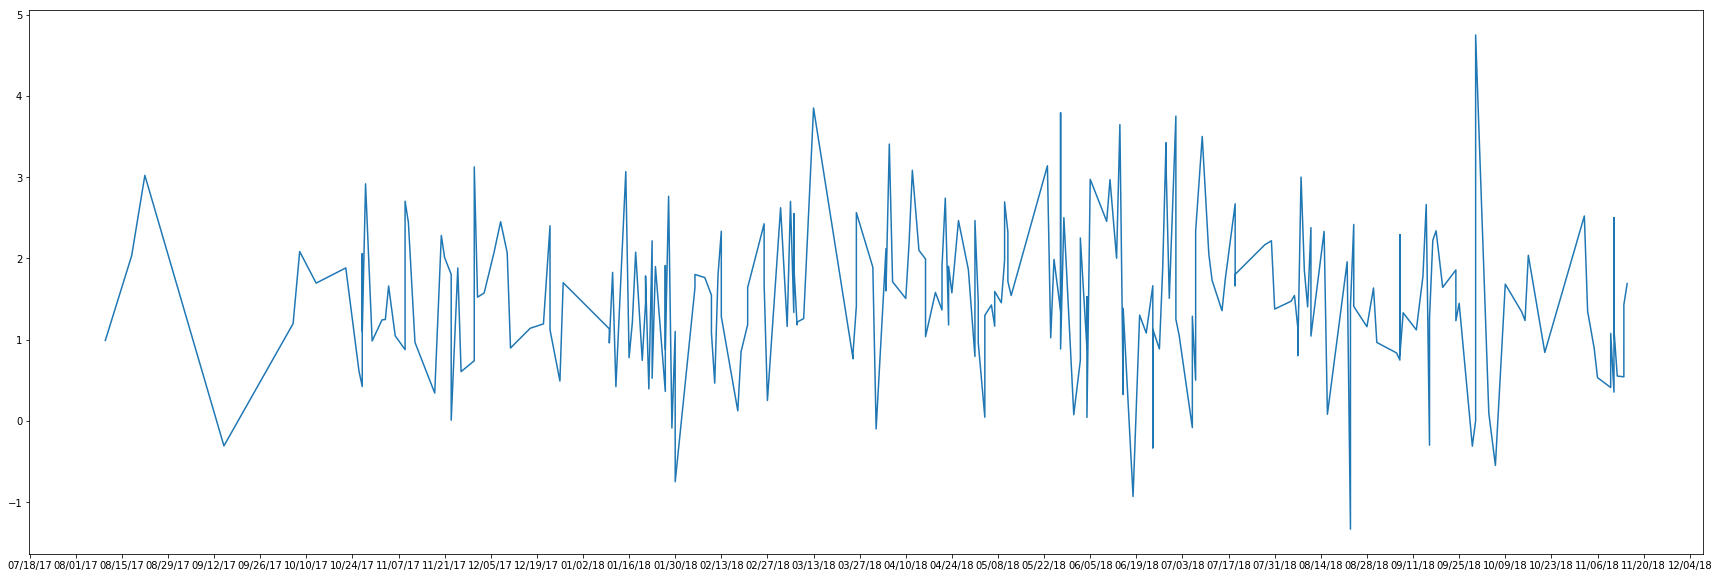

In [21]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(yelp_data['Date'],5*yelp_data['Sentiment'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

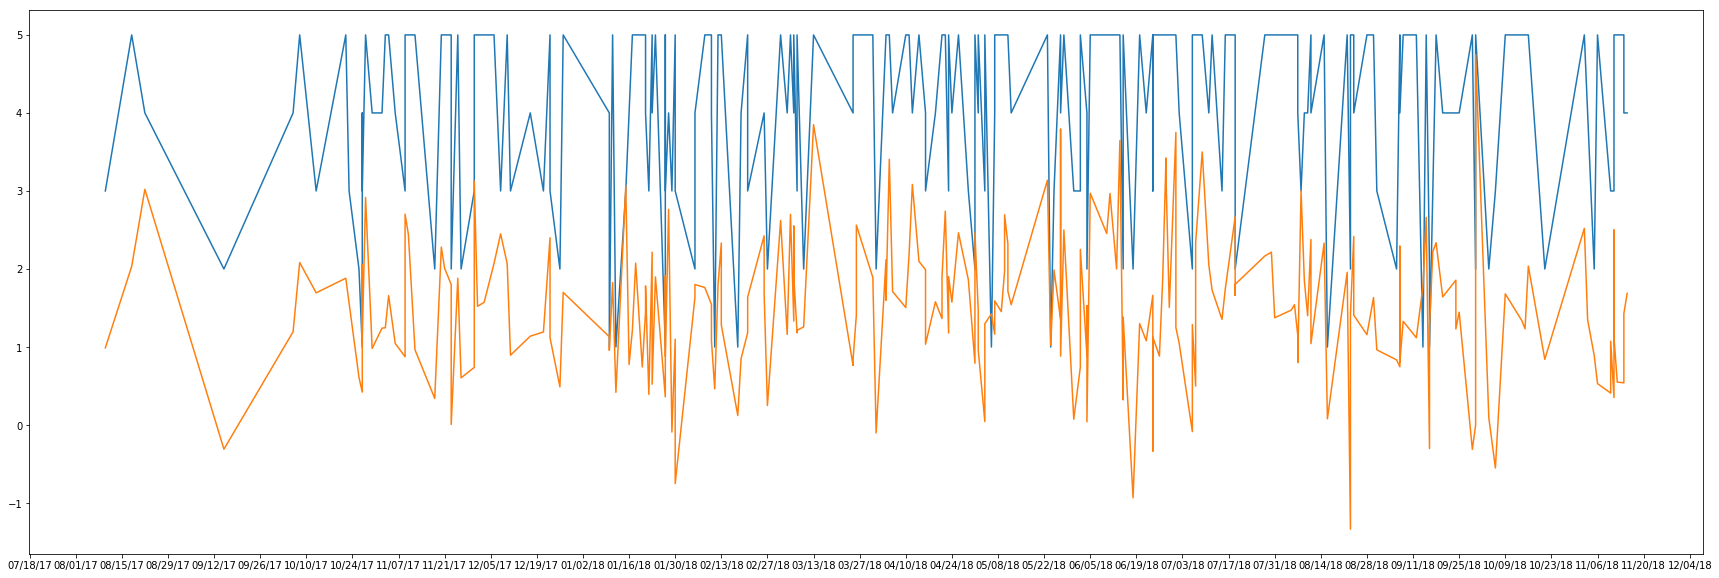

In [22]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(yelp_data['Date'],yelp_data['Rating'])
plt.plot(yelp_data['Date'],5*yelp_data['Sentiment'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

Here we group the data by date in order to use it in conjunction with the weather data. We average the ratings per day and eventually use it with the averaged temperatures per day.

In [23]:
groups = yelp_data.groupby(yelp_data['Date'])
yelp_data_ave_date = []
yelp_data_ave_rating = []
for i in yelp_data['Date'].unique():
    yelp_data_ave_date.append(i)
    yelp_data_ave_rating.append(np.mean(groups.get_group(i)['Rating']))

In [24]:
yelp_data_ave = pd.DataFrame({'Date': yelp_data_ave_date,'Average Rating':yelp_data_ave_rating})

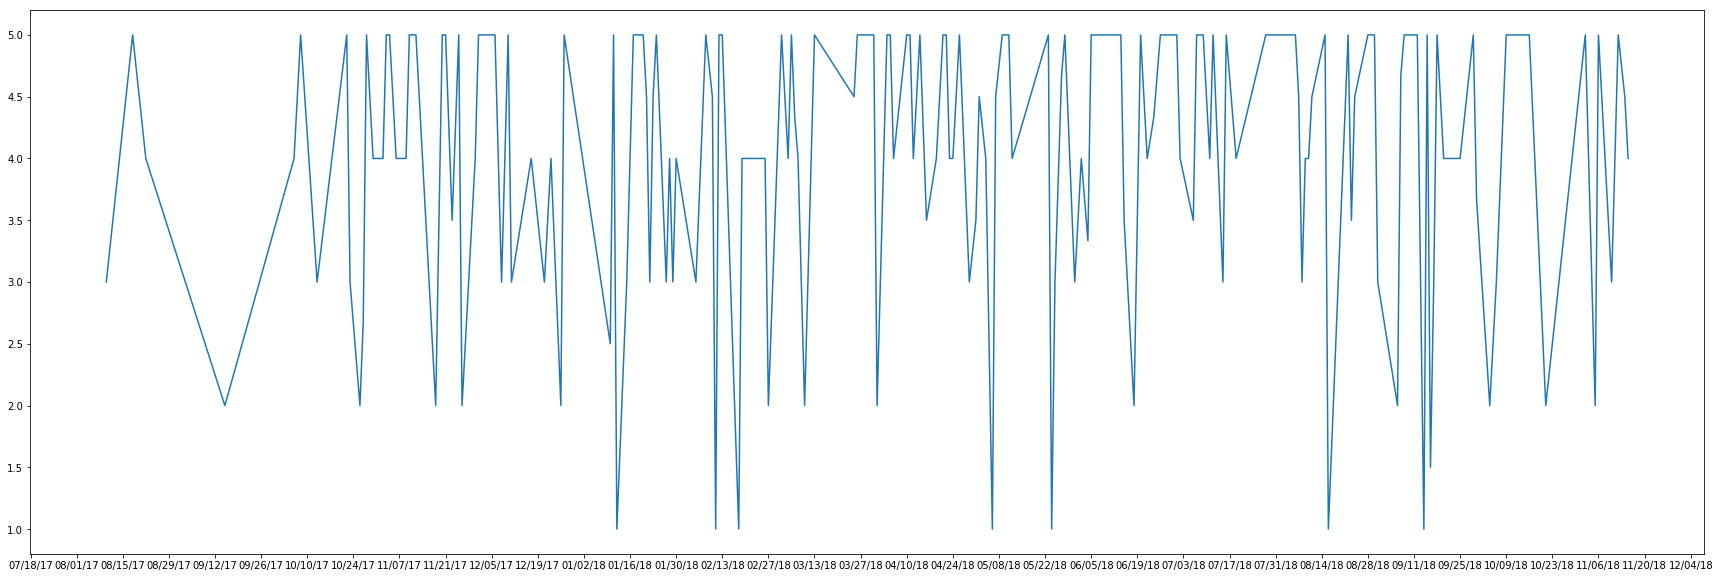

In [25]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(yelp_data_ave['Date'],yelp_data_ave['Average Rating'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

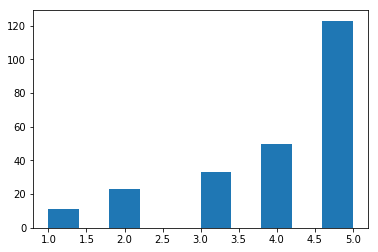

In [26]:
plt.hist(yelp_data['Rating'])
plt.show()

# Length of Review

In [27]:
def count(review):
    count = len(re.findall(r'\w+', review))
    return count
    
count_list = []
for review in yelp_data['Review']:
    count_list.append(count(review))
for count in count_list:
    yelp_data["Count"] = [i for i in count_list]
    
yelp_data.head()

,Review,Rating,Date,Sentiment,Count
0,If second time is the charm then our dinner on...,4.0,2018-11-15,0.337662,171
1,"Very good. But I guess with all the hype, I w...",4.0,2018-11-14,0.285833,92
2,This has been on my bucket list for a while bu...,5.0,2018-11-14,0.108203,356
3,My boyfriend and I had an amazing experience a...,5.0,2018-11-12,0.110115,264
4,Ok where do I start I think if you reserved th...,5.0,2018-11-11,0.224017,191


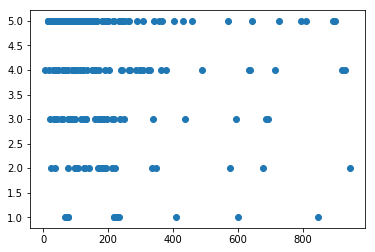

In [28]:
plt.scatter(yelp_data["Count"],yelp_data["Rating"])
plt.show()

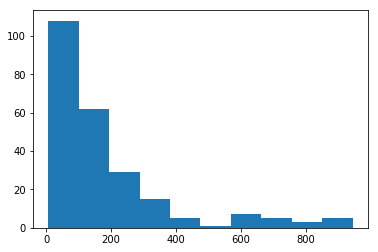

In [29]:
plt.hist(yelp_data["Count"])
plt.show()

# Weather Data Processing

In [30]:
df = pd.read_csv("owm09172017_09172018.csv")

In [31]:
acc=0
date_temp={}
acc=0
for i in range(0,len(df)-1):
    key = df["DATE"][i][0:10]
    temp = df["HOURLYDewPointTempC"][i]
    if (not math.isnan(temp)):
        if (key in date_temp):
            acc+=1
            date_temp[key].append(temp)
        else:
            acc=0
            date_temp[key] = [temp]

In [32]:
daily_ave_temp_c={}
for x in date_temp:
    daily_ave_temp_c[x]=np.mean(date_temp[x])

In [33]:
dictlist=[]
for key, value in daily_ave_temp_c.items():
    temp = [key,value]
    dictlist.append(temp)

In [34]:
new_df = pd.DataFrame(dictlist)
new_df[0]=pd.to_datetime(new_df[0])

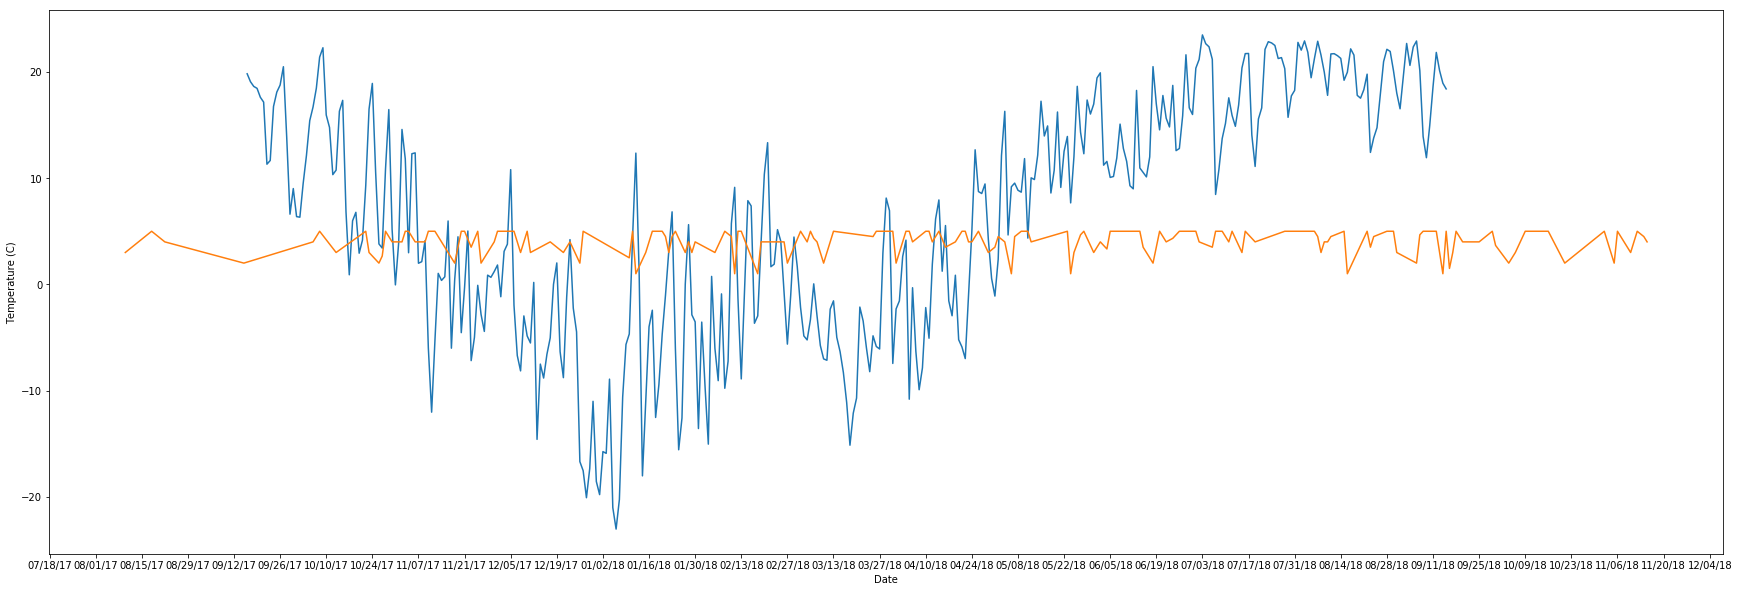

In [35]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(new_df[0],(new_df[1]),animated=True)
plt.plot(yelp_data_ave['Date'],(yelp_data_ave['Average Rating']))
ax.set(xlabel="Date", ylabel="Temperature (C)")
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

plt.show()

# Dataframe that joints Temperature into Yelp_Data by date


In [36]:
new_df.head(5)

,0,1
0,2017-09-16,19.830769
1,2017-09-17,19.085714
2,2017-09-18,18.641667
3,2017-09-19,18.459375
4,2017-09-20,17.619444


In [37]:
new_df_dict = new_df.to_dict('records')

In [38]:
for x in new_df_dict:
    print(x)

{0: Timestamp('2017-09-16 00:00:00'), 1: 19.830769230769228}
{0: Timestamp('2017-09-17 00:00:00'), 1: 19.085714285714285}
{0: Timestamp('2017-09-18 00:00:00'), 1: 18.641666666666666}
{0: Timestamp('2017-09-19 00:00:00'), 1: 18.459375}
{0: Timestamp('2017-09-20 00:00:00'), 1: 17.61944444444445}
{0: Timestamp('2017-09-21 00:00:00'), 1: 17.162499999999998}
{0: Timestamp('2017-09-22 00:00:00'), 1: 11.316666666666668}
{0: Timestamp('2017-09-23 00:00:00'), 1: 11.665384615384616}
{0: Timestamp('2017-09-24 00:00:00'), 1: 16.754166666666666}
{0: Timestamp('2017-09-25 00:00:00'), 1: 18.108333333333334}
{0: Timestamp('2017-09-26 00:00:00'), 1: 18.765625}
{0: Timestamp('2017-09-27 00:00:00'), 1: 20.4969696969697}
{0: Timestamp('2017-09-28 00:00:00'), 1: 13.884848484848487}
{0: Timestamp('2017-09-29 00:00:00'), 1: 6.608333333333333}
{0: Timestamp('2017-09-30 00:00:00'), 1: 9.020512820512822}
{0: Timestamp('2017-10-01 00:00:00'), 1: 6.378571428571428}
{0: Timestamp('2017-10-02 00:00:00'), 1: 6.325}


In [39]:
yelp_data.head(5)

,Review,Rating,Date,Sentiment,Count
0,If second time is the charm then our dinner on...,4.0,2018-11-15,0.337662,171
1,"Very good. But I guess with all the hype, I w...",4.0,2018-11-14,0.285833,92
2,This has been on my bucket list for a while bu...,5.0,2018-11-14,0.108203,356
3,My boyfriend and I had an amazing experience a...,5.0,2018-11-12,0.110115,264
4,Ok where do I start I think if you reserved th...,5.0,2018-11-11,0.224017,191


In [40]:
temp_lst=[]
for date in yelp_data['Date']:
    switch = True
    for x in new_df_dict:
        if x[0] == date:
            temp_lst.append(x[1])
            switch = False
    if switch:
        temp_lst.append(x[1])


In [41]:
yelp_data["Temp"] = [x for x in temp_lst]

In [42]:
yelp_data.head(20)

,Review,Rating,Date,Sentiment,Count,Temp
0,If second time is the charm then our dinner on...,4.0,2018-11-15,0.337662,171,18.406667
1,"Very good. But I guess with all the hype, I w...",4.0,2018-11-14,0.285833,92,18.406667
2,This has been on my bucket list for a while bu...,5.0,2018-11-14,0.108203,356,18.406667
3,My boyfriend and I had an amazing experience a...,5.0,2018-11-12,0.110115,264,18.406667
4,Ok where do I start I think if you reserved th...,5.0,2018-11-11,0.224017,191,18.406667
5,Outstanding dining experience at Eleven Madiso...,4.0,2018-11-11,0.500000,7,18.406667
6,The food other than the dessert was mostly gre...,3.0,2018-11-11,0.070536,95,18.406667
7,"Ok, if this was just another regular ole resta...",3.0,2018-11-10,0.215085,238,18.406667
8,Disappointing. Can't believe this was #1 (and ...,3.0,2018-11-10,0.081944,132,18.406667
9,Loved came with a hot escort and had champagne...,5.0,2018-11-06,0.106250,26,18.406667


# Statistics about Reviews

In [43]:
# Mean of all ratings
yelp_raings = np.array([float(i) for i in yelp_data['Rating']])

In [44]:
np.mean(yelp_raings)

4.045833333333333

In [45]:
np.std(yelp_raings)

1.2015542596524258

In [46]:
def normal(x, mean, std_dev):
    result = 1.0 / (std_dev * np.sqrt(2 * np.pi))
    result *= np.exp(-(x - mean)**2/ (2*std_dev**2))
    return result

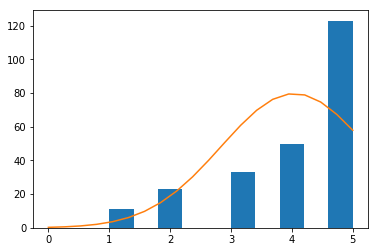

In [47]:
x = np.linspace(0, 5, 20)
plt.hist(yelp_raings)
plt.plot(x, 240*normal(x, 4.04, 1.201))
plt.show()

The rating distribution has mostly biases towards 5 starts.
And it is sensible in that these reviews are collected from EMP, which is Michelin 3 star restaurants that has been rated the best all the best. Therefore, it is expected that its ratings do not necessarily for a normal distribution. 

In [48]:
yelp_sent = np.array([float(i) for i in yelp_data['Sentiment']])

In [49]:
np.mean(yelp_sent)

0.30162550477721317

In [50]:
np.std(yelp_sent)

0.183837990789535

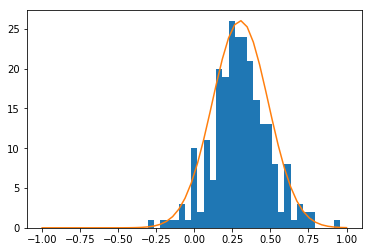

In [51]:
x_1 = np.linspace(-1, 1)
plt.hist(yelp_sent, bins=np.linspace(-1,1))
plt.plot(x_1, 12*normal(x_1, 0.3016, 0.1838799))
plt.show()

Interestingly, the sentiment analysis distribution looks pretty close to normal. It is not quite intuitive though, since we indeed could notice some correlation from the graph above which plots both Rating and Sentiment with respect to Date. 

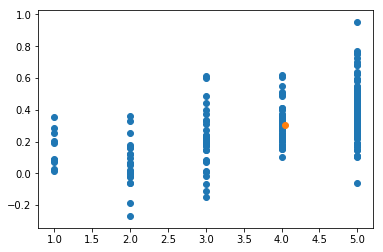

In [184]:
plt.scatter(yelp_raings, yelp_sent) # the x_0, x_1 pairs in blue
plt.scatter(np.mean(yelp_raings), np.mean(yelp_sent) )# the mean in green
plt.show()

In [53]:
# first, let's calculate the variance of the two dimensions.
#  the `ddof=1` argument means divide by (n-1) instead of n.
# it's around 1, which is good since these values are from
#  a normal with variance 1, and sample size 100.
yelp_raings.var(ddof=1)

1.4497733612273362

In [54]:
# same with the second column. this one is quite close to 1.0.
yelp_sent.var(ddof=1)

0.033937814417606516

In [55]:
np.corrcoef(yelp_raings,yelp_sent)

array([[1.        , 0.54933637],
       [0.54933637, 1.        ]])

In [56]:
np.cov(yelp_raings,yelp_sent)

array([[1.44977336, 0.12185135],
       [0.12185135, 0.03393781]])

Correlation coefficient is more well-behaved. Here we get a correlation of 0.549, which is pretty large for such variable data.

## Weather and Rating Stats

In [57]:
temp = np.array(yelp_data['Temp'])

In [58]:
temp.mean()

8.543014652436481

In [59]:
temp.var()

101.05716238879263

In [60]:
temp.std()

10.052719153979814

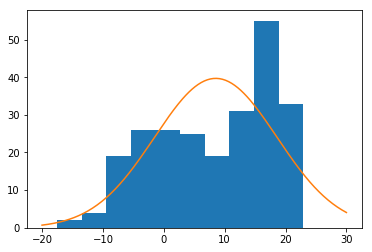

In [61]:
x = np.linspace(-20, 30, 200)
plt.hist(temp)
plt.plot(x, 1000*normal(x, 8.54, 10.0527))
plt.show()

In [62]:
np.cov(yelp_data['Rating'],yelp_data['Temp'])

array([[  1.44977336,   0.16392698],
       [  0.16392698, 101.4799957 ]])

In [63]:
np.corrcoef(yelp_data['Rating'],yelp_data['Temp'])

array([[1.        , 0.01351482],
       [0.01351482, 1.        ]])

In [64]:
def get_linear_model(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    sum_x_squared = np.sum((x - x_mean)**2)
    sum_y_squared = np.sum((y - y_mean)**2)
    sum_x_y = np.sum((x - x_mean) * (y - y_mean))
    
    slope = sum_x_y / sum_x_squared
    intercept = y_mean - x_mean * slope

    predictions = x * slope + intercept
    sum_squared_error = np.sum((y - predictions)**2)
    standard_error = np.sqrt(sum_squared_error / ((len(x) - 2) * sum_x_squared))
    
    return { "slope": slope, "intercept": intercept, "standard_error": standard_error }
def predict(x, model):
    return x * model["slope"] + model["intercept"]

In [65]:
model = get_linear_model(temp, yelp_raings)
print(model) 

{'slope': 0.001615362476774182, 'intercept': 4.0320332680252555, 'standard_error': 0.007746966778070541}


In [66]:
x_extent = np.array([temp.min(), temp.max()])
print(predict(x_extent, model))

[4.00368366 4.06905536]


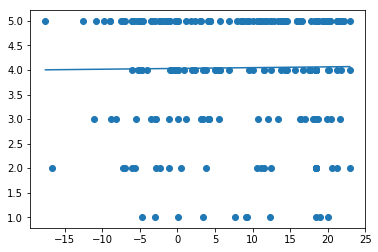

In [67]:
plt.scatter(temp, yelp_raings)
plt.plot( x_extent, predict(x_extent, model) )
plt.show()

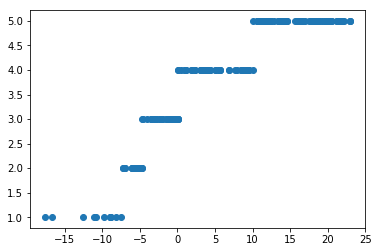

In [68]:
plt.scatter(np.sort(temp), np.sort(yelp_raings))
plt.show()

After calculating and plotting out temperature data and reviews, we pretty much can conclude that temperature does not necessarily have an effect on how people enjoy their dinner at EMP. However, we are exploring this in a more general scope in order to better sense a potential correlation between weather and yelp reviews. That being said, we believe it would make sense if we take reviews from other restaurants into consideration and compare all those average ratings with temperatures. 

# More Restaurants

In [69]:
# Reviews
# This is the reviews for Upstate
urls = []
c = 120
for i in range(12): 
    new = "https://www.yelp.com/biz/upstate-new-york-2?start="+str(c)+"&sort_by=date_desc"
    urls.append(new)
    c+=20
Reviews_mad = []
for url in urls:
    html = urlopen(url)
    bsObj4 = BeautifulSoup(html)
   
    reviewers = bsObj4.find_all('div', {'itemprop': 'review'})
    for name in reviewers:
        Reviews_mad.append(name.get_text())

In [70]:
date_mad = []
Ratings_mad = []
for url in urls:
    html = urlopen(url)
    bsObj4 = BeautifulSoup(html)
    for name in bsObj4.find_all('meta', {'itemprop': 'datePublished'}):
        date_mad.append(name.get("content"))
    for reviewBody in bsObj4.findAll('div',{"class":"review-content"}):
        Ratings_mad.append(reviewBody.div.div.div.get("title"))


In [71]:
yelp_data_upstate = pd.DataFrame({'Review': Reviews_mad,'Rating':Ratings_mad, 'Date': date_mad})
yelp_data_upstate['Review'] = [i.replace('\n', '') for i in yelp_data_upstate['Review']]
yelp_data_upstate['Rating'] = [float(re.sub(r'[^\d.]+','', i)) for i in yelp_data_upstate['Rating']]
yelp_data_upstate["Date"] = [pd.to_datetime(i) for i in yelp_data_upstate["Date"]]

temp_lst=[]
for date in yelp_data_upstate['Date']:
    switch = True
    for x in new_df_dict:
        if x[0] == date:
            temp_lst.append(x[1])
            switch = False
    if switch:
        temp_lst.append(x[1])
yelp_data_upstate["Temp"] = [x for x in temp_lst]

In [72]:
yelp_data_upstate.head(5)

,Review,Rating,Date,Temp
0,I would give this place a 5 star but the humpt...,4.0,2018-10-06,18.406667
1,I went here last week with my friend for the o...,4.0,2018-10-05,18.406667
2,The rating is misleadingly high. It's not a ba...,3.0,2018-09-29,18.406667
3,Upstate is a super cute date spot but can feel...,4.0,2018-09-26,18.406667
4,Fresh oysters but ultra rude staff. Yes don't ...,1.0,2018-09-26,18.406667


In [73]:
sentiment_list_upstate = []
for review in yelp_data_upstate['Review']:
    sentiment_list_upstate.append(review_sentiment(review))
for sent in sentiment_list:
    yelp_data_upstate["Sentiment"] = [i for i in sentiment_list_upstate]

In [74]:
yelp_data_upstate.to_csv("yelp_data_upstate.csv")
yelp_data_upstate.head(5)


,Review,Rating,Date,Temp,Sentiment
0,I would give this place a 5 star but the humpt...,4.0,2018-10-06,18.406667,0.307576
1,I went here last week with my friend for the o...,4.0,2018-10-05,18.406667,0.185897
2,The rating is misleadingly high. It's not a ba...,3.0,2018-09-29,18.406667,0.436735
3,Upstate is a super cute date spot but can feel...,4.0,2018-09-26,18.406667,0.370614
4,Fresh oysters but ultra rude staff. Yes don't ...,1.0,2018-09-26,18.406667,0.158306


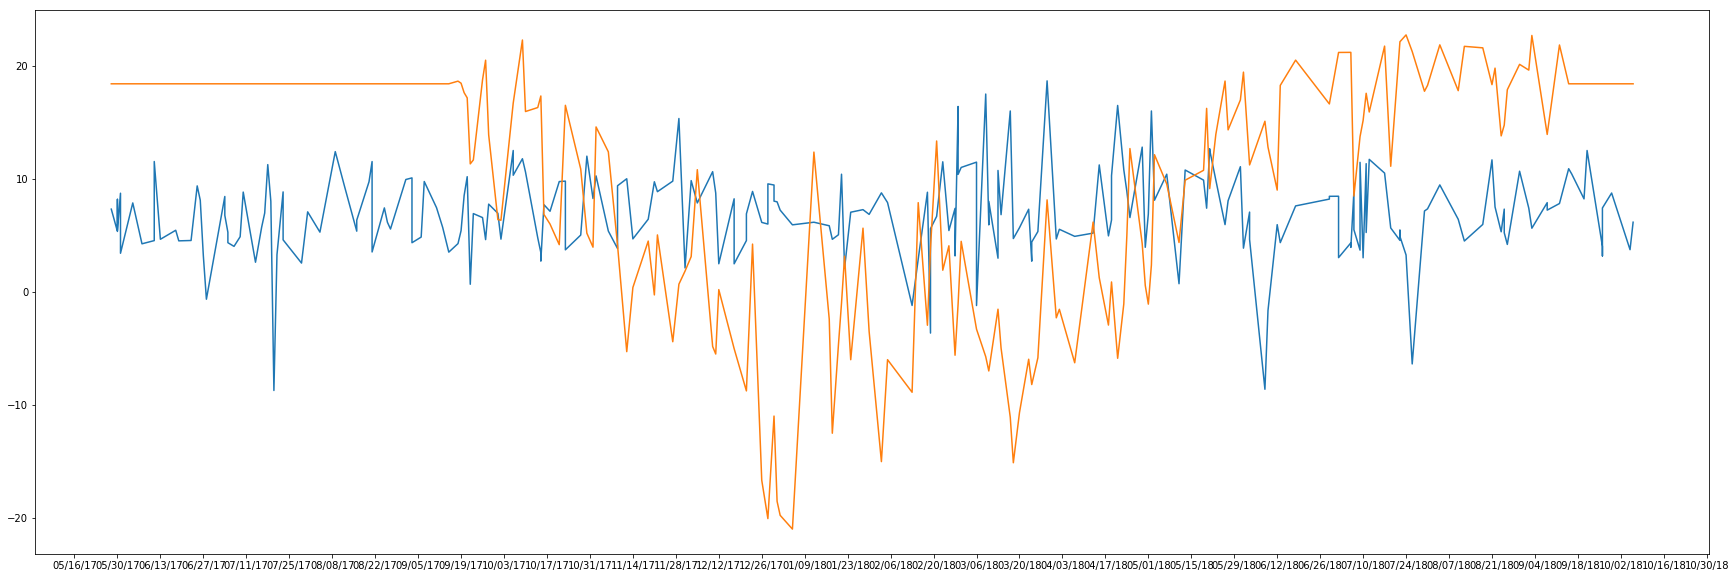

In [75]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(yelp_data_upstate['Date'],20*yelp_data_upstate['Sentiment'])
plt.plot(yelp_data_upstate['Date'],yelp_data_upstate['Temp'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

In [76]:
yelp_data_upstate = yelp_data_upstate[ yelp_data_upstate["Date"] > "2017-08-10" ]
yelp_data_upstate = yelp_data_upstate[ yelp_data_upstate["Date"] < "2018-07-10" ]
yelp_data_upstate.sort_values("Date")


,Review,Rating,Date,Temp,Sentiment
201,This place is a gem in the East Village. It ...,5.0,2017-08-12,18.406667,0.467187
200,I fell in love with this cute restaurant. The ...,4.0,2017-08-16,18.406667,0.267857
199,Wow was this place a great experience! I was i...,5.0,2017-08-16,18.406667,0.316531
198,"The food is good, but not as amazing as I was ...",3.0,2017-08-20,18.406667,0.486667
196,A solid 3.5 stars for this quaint little resta...,4.0,2017-08-21,18.406667,0.175781
197,This restaurant is very popular as there was o...,5.0,2017-08-21,18.406667,0.576000
195,Great fresh seafood for great price. I absolut...,5.0,2017-08-25,18.406667,0.370833
194,Found this place randomly while I was walking ...,5.0,2017-08-26,18.406667,0.307143
193,"I just moved to glorious East Village, and I c...",5.0,2017-08-27,18.406667,0.277348
192,We attended several oyster happy hours on our ...,5.0,2017-09-01,18.406667,0.496588


In [77]:
yelp_data = yelp_data[ yelp_data["Date"] > "2017-08-10" ]
yelp_data = yelp_data[ yelp_data["Date"] < "2018-07-10" ]
yelp_data.sort_values("Date")

,Review,Rating,Date,Sentiment,Count,Temp
238,Professional as can be. Felt like a king being...,5.0,2017-08-18,0.406667,25,18.406667
237,Delicious food and great service!! We went the...,4.0,2017-08-22,0.604167,29,18.406667
236,"April 23, 201712:00 PM4 GuestsMaybe an off nig...",2.0,2017-09-15,-0.061810,187,18.406667
235,"The restaurant, designed by Bentel & Bentel, i...",4.0,2017-10-06,0.239150,122,16.704167
234,Went there for hubbys date night and was surp...,5.0,2017-10-08,0.416667,52,21.400000
233,"I have been super excited to try EMP, especial...",3.0,2017-10-13,0.338938,438,10.757143
232,Impeccable dining experience at the world no. ...,5.0,2017-10-22,0.376308,104,9.304167
231,I came here to celebrate my birthday. The spa...,3.0,2017-10-23,0.311364,96,16.502564
230,Overall very disappointing. when you wait at t...,2.0,2017-10-26,0.122407,193,3.808333
229,Thoroughly unimpressed. The service was atten...,1.0,2017-10-27,0.084333,75,3.415385


In [78]:
merged = pd.merge(yelp_data,yelp_data_upstate,left_on='Date',right_on='Date')

In [79]:
merged.head(5)

,Review_x,Rating_x,Date,Sentiment_x,Count,Temp_x,Review_y,Rating_y,Temp_y,Sentiment_y
0,Great place to enjoy great company with excell...,5.0,2018-07-09,0.70000,16,13.729167,"The oysters are fresh. And, the wine selection...",5.0,13.729167,0.572500
1,Great place to enjoy great company with excell...,5.0,2018-07-09,0.70000,16,13.729167,"Cool place to have dinner, especially their oy...",5.0,13.729167,0.183952
2,This was one of my favorite tasting menu exper...,5.0,2018-07-07,0.46713,158,8.466667,I was expecting more from this place given the...,2.0,8.466667,0.274250
3,This was one of my favorite tasting menu exper...,5.0,2018-07-07,0.46713,158,8.466667,The servers are welcoming and the food is deli...,4.0,8.466667,0.442857
4,Not much else to add beyond the glowing review...,5.0,2018-07-07,0.10000,37,8.466667,I was expecting more from this place given the...,2.0,8.466667,0.274250


In [109]:
merged['Ave'] = (merged['Sentiment_x']+merged['Sentiment_y'])/2
merged['Ave_R'] = (merged['Rating_x']+merged['Rating_y'])/2

In [151]:
merged.head(5)

,Review_x,Rating_x,Date,Sentiment_x,Count,Temp_x,Review_y,Rating_y,Temp_y,Sentiment_y,Ave,Ave_R
0,Great place to enjoy great company with excell...,5.0,2018-07-09,0.70000,16,13.729167,"The oysters are fresh. And, the wine selection...",5.0,13.729167,0.572500,0.636250,5.0
1,Great place to enjoy great company with excell...,5.0,2018-07-09,0.70000,16,13.729167,"Cool place to have dinner, especially their oy...",5.0,13.729167,0.183952,0.441976,5.0
2,This was one of my favorite tasting menu exper...,5.0,2018-07-07,0.46713,158,8.466667,I was expecting more from this place given the...,2.0,8.466667,0.274250,0.370690,3.5
3,This was one of my favorite tasting menu exper...,5.0,2018-07-07,0.46713,158,8.466667,The servers are welcoming and the food is deli...,4.0,8.466667,0.442857,0.454993,4.5
4,Not much else to add beyond the glowing review...,5.0,2018-07-07,0.10000,37,8.466667,I was expecting more from this place given the...,2.0,8.466667,0.274250,0.187125,3.5


In [170]:
merged["Ave"] = minmax_scaling(merged["Ave"], columns = [0])
merged["Ave_R"] = minmax_scaling(merged["Ave_R"], columns = [0])

In [171]:
merged.head()

,Review_x,Rating_x,Date,Sentiment_x,Count,Temp_x,Review_y,Rating_y,Temp_y,Sentiment_y,Ave,Ave_R
0,Great place to enjoy great company with excell...,5.0,2018-07-09,0.70000,16,13.729167,"The oysters are fresh. And, the wine selection...",5.0,13.729167,0.572500,0.974112,1.0
1,Great place to enjoy great company with excell...,5.0,2018-07-09,0.70000,16,13.729167,"Cool place to have dinner, especially their oy...",5.0,13.729167,0.183952,0.679711,1.0
2,This was one of my favorite tasting menu exper...,5.0,2018-07-07,0.46713,158,8.466667,I was expecting more from this place given the...,2.0,8.466667,0.274250,0.571685,0.4
3,This was one of my favorite tasting menu exper...,5.0,2018-07-07,0.46713,158,8.466667,The servers are welcoming and the food is deli...,4.0,8.466667,0.442857,0.699437,0.8
4,Not much else to add beyond the glowing review...,5.0,2018-07-07,0.10000,37,8.466667,I was expecting more from this place given the...,2.0,8.466667,0.274250,0.293513,0.4


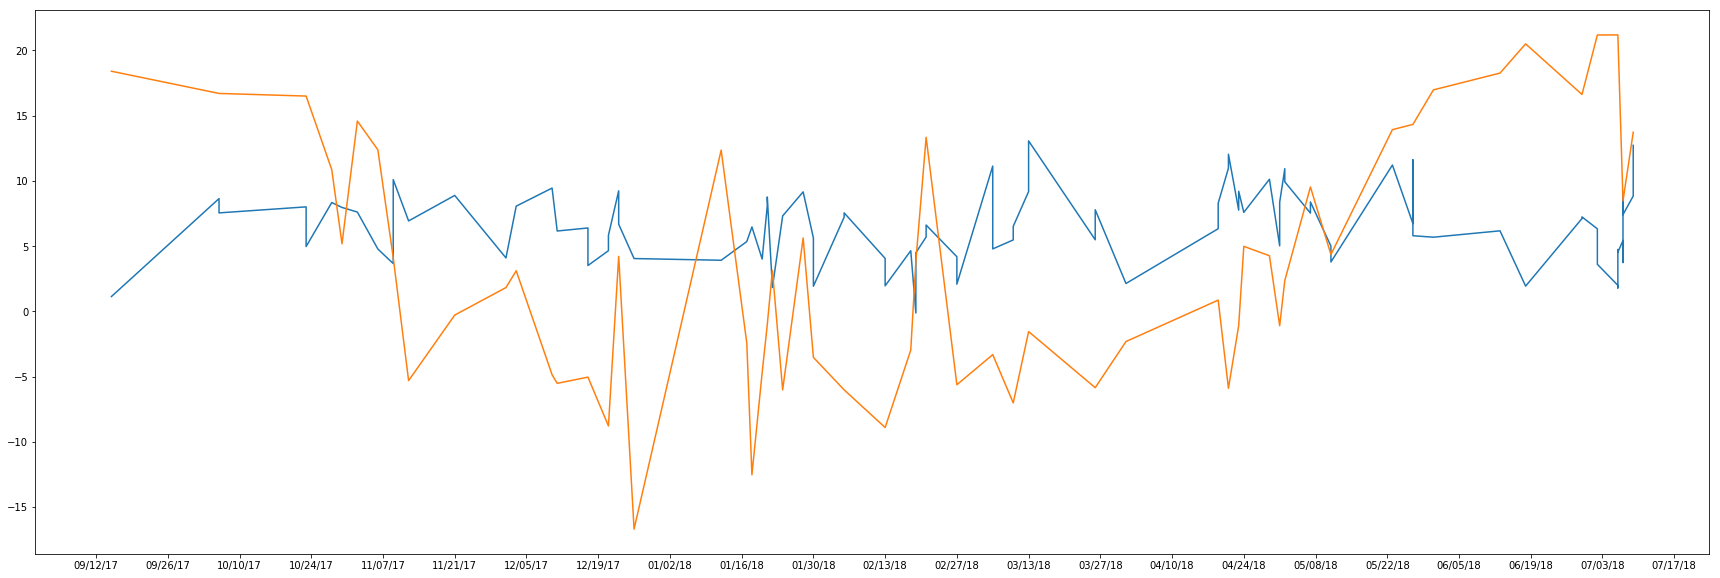

In [82]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(merged['Date'],20*merged['Ave'])
plt.plot(merged['Date'],merged['Temp_x'])
FMT = DateFormatter("%m/%d") 
ax.xaxis.set_major_formatter(FMT) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator( interval=2))

# Linear Regression

In [139]:
rating_sentiment_model = LinearRegression().fit(yelp_data["Rating"].values.reshape(-1, 1),
                                    yelp_data["Sentiment"]) 

In [140]:
rating_sentiment_model.coef_

array([0.09201159])

In [172]:
rating_sentiment_model_merged = LinearRegression().fit(merged["Ave_R"].values.reshape(-1, 1),
                          
                                                       merged["Ave"]) 

In [173]:
rating_sentiment_model_merged.coef_

array([0.49005364])

In [174]:
rating_temp_model = LinearRegression().fit(yelp_data["Temp"].values.reshape(-1, 1),
                                    yelp_data["Rating"]) 

In [175]:
rating_temp_model.coef_

array([0.00559284])

In [176]:
sentiment_temp_model = LinearRegression().fit(yelp_data["Temp"].values.reshape(-1, 1),
                                    yelp_data["Sentiment"]) 

In [177]:
sentiment_temp_model.coef_

array([3.10163661e-05])

In [178]:
rating_temp_model_merged = LinearRegression().fit(merged["Temp_x"].values.reshape(-1, 1),
                                    merged["Ave_R"]) 

In [179]:
rating_temp_model_merged.coef_

array([0.0034568])

In [180]:
sentiment_temp_model_merged = LinearRegression().fit(merged["Temp_x"].values.reshape(-1, 1),
                                    merged["Ave"]) 

In [181]:
sentiment_temp_model_merged.coef_

array([-0.00083239])

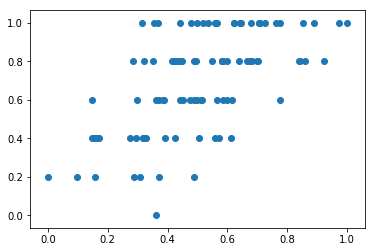

In [182]:
plt.scatter(merged["Ave"],merged["Ave_R"])

# Naive Bayes Classification 

Here we use the Naive Bayes Classification we learned in class from problem set 2 that trains based on initial positive and negative reviews to identify within our collected data whether certain reviews are negative, positive, or neutral. The reason we are trying naive based classification (in addition to TextBlob built in package) is to see whether there is a difference in how the two classify reviews.

In [83]:
letter_pattern = re.compile("[A-Za-z']+")
pos_words_counter = collections.Counter()
num_pos_revs= 0

neg_words_counter = collections.Counter()
num_neg_revs= 0

with open("positive.txt") as file: 
    for line in file.readlines():
        pos_words_counter.update(letter_pattern.findall(line))
        num_pos_revs +=1

with open("negative.txt") as file: 
    for line in file.readlines():
        neg_words_counter.update(letter_pattern.findall(line))
        num_neg_revs +=1

  

In [84]:
total_revs = num_pos_revs+num_neg_revs
prob_pos_rev = num_pos_revs/(total_revs)
prob_neg_rev = num_neg_revs/(total_revs)

positive_tokens=sum(pos_words_counter.values())
negative_tokens= sum(neg_words_counter.values())


In [85]:
def word_prob(word,counter,summation):
    word_occurence = counter[word]
    return word_occurence/summation

In [86]:
def review_prob(sentence,counter,summation):
    total_prob = 1
    letter_pattern = re.compile("[A-Za-z']+")
    sentence_to_words = letter_pattern.findall(sentence)
    print(sentence_to_words)
    for word in  sentence_to_words:
        total_prob =total_prob*word_prob(word,counter,summation)
    return total_prob

In [87]:
def word_log_prob(word,counter,summation):
    word_occurence = counter[word]
    p = word_occurence/summation
    return log(p)

def review_log_prob(sentence,counter,summation):
    total_prob = 0
    letter_pattern = re.compile("[A-Za-z']+")
    sentence_to_words = letter_pattern.findall(sentence)
    print(sentence_to_words)
    for word in  sentence_to_words:
        
        total_prob =total_prob+word_log_prob(word,counter,summation)
    return total_prob

In [88]:
both_counts = pos_words_counter+neg_words_counter
both_tokens =  positive_tokens+negative_tokens
vocabulary_size = len(both_counts)


In [89]:
def smoothed_word_log_prob(word, counter, sum_of_the_counter):
    word_occurence = counter[word]+1
    sum_of_the_counter = sum_of_the_counter+ vocabulary_size# +1 for each unique word?
    p = word_occurence/sum_of_the_counter
    return(log(p))

In [90]:
def smoothed_sentence_log_prob(sentence,counter,summation):
    total_prob = 0
    letter_pattern = re.compile("[A-Za-z']+")
    sentence_to_words = letter_pattern.findall(sentence)
    print(sentence_to_words)
    for word in  sentence_to_words:
        total_prob =total_prob+smoothed_word_log_prob(word,counter,summation)
    return total_prob

def ratio(sentence, counter, sum_of_the_counter,prob_of_rev):
   # P(w1,w2,etc.|pos)*P(pos)
    p_words_given_rev = smoothed_sentence_log_prob(sentence,counter,sum_of_the_counter)+log(prob_of_rev)
    return p_words_given_rev
    # P(w1,w2,etc.|pos)*P(pos)
    #p_words_given_neg =smoothed_sentence_log_prob(sentence,counter,sum_of_the_counter)*log(prob_neg_rev)  




In [91]:
NBC_sentiment_list = []
for review in yelp_data['Review']: 
   
    pos_ratio = ratio(review,pos_words_counter,positive_tokens,prob_pos_rev)
    neg_ratio =  ratio(review,neg_words_counter,negative_tokens,prob_neg_rev)   
    NBC_sentiment_list.append(pos_ratio-neg_ratio)

for sent in NBC_sentiment_list:
    yelp_data["NBC_sentiment"] = [i for i in NBC_sentiment_list]

['Great', 'place', 'to', 'enjoy', 'great', 'company', 'with', 'excellent', 'food', 'Really', 'enjoyed', 'the', 'art', 'the', 'chef', 'prepared']
['Great', 'place', 'to', 'enjoy', 'great', 'company', 'with', 'excellent', 'food', 'Really', 'enjoyed', 'the', 'art', 'the', 'chef', 'prepared']
['This', 'was', 'one', 'of', 'my', 'favorite', 'tasting', 'menu', 'experiences', 'It', 'was', 'fancy', 'but', 'still', 'managed', 'to', 'feel', 'upbeat', 'and', 'relaxed', 'Everything', 'we', 'had', 'was', 'delicious', 'and', 'unique', 'The', 'staff', 'was', 'fun', 'and', 'the', 'presentation', 'of', 'everything', 'was', 'incredible', 'Not', 'to', 'mention', 'we', 'were', 'sent', 'away', 'with', 'a', 'tin', 'that', 'we', 'ate', 'out', 'of', 'earlier', 'full', 'of', 'our', 'menu', 'and', 'a', 'big', 'jar', 'of', 'granola', 'for', 'breakfast', 'My', 'absolute', 'favorites', 'of', 'the', 'night', 'were', 'the', 'egg', 'salad', 'asparagus', 'and', 'snow', 'pea', 'fish', 'egg', 'starters', 'the', 'bread', 

In [92]:
len(yelp_data)

170

Made assumption based on Textblob polarity distribution seen earlier, which showed to be normally distributed, that we can split the thresholds into 3 categories directly by dividing the reviews in 1/3.
Which is 170/3 = 57
Such that, when sorting based on NBC_sentiment in descensing order, top 0-60 are pos, 60-121 are neutral, and 121-170 are neg.

In [93]:
sort_by_nbcsent_descending = yelp_data.sort_values("NBC_sentiment",ascending=False)

sort_by_nbcsent_descending.head()

,Review,Rating,Date,Sentiment,Count,Temp,NBC_sentiment
156,So this restaurant is definitely up there in m...,4.0,2018-03-05,0.232251,928,-5.233333,132.984881
189,I'm not sure what there is to say that's not a...,5.0,2018-01-17,0.242952,900,-2.436842,129.622519
93,We dined at EMP tonight to celebrate a birthda...,5.0,2018-06-10,0.491004,431,11.579167,127.845476
115,"TLDR: worth checking out for the experience, b...",4.0,2018-05-07,0.232915,634,9.534615,114.261514
159,I really want to do justice to this amazing ex...,4.0,2018-02-26,0.336112,715,-0.772000,93.095599


Here a new column is added into the dataset based on the thresholds which assign the label based on the data sorted based on NBC_sentiment in descending order and split into 3. 1 being positive, 0 being neutral, and -1 being negative.

In [94]:
sort_by_nbcsent_descending["label"] = ["none"] * 170
sort_by_nbcsent_descending.head()
sort_by_nbcsent_descending["label"][0:60] =[1 for i in sort_by_nbcsent_descending.iloc[0:60]["NBC_sentiment"]]
sort_by_nbcsent_descending["label"][60:121] =[0 for i in sort_by_nbcsent_descending.iloc[60:121]["NBC_sentiment"]]
sort_by_nbcsent_descending["label"][121:170] =[-1 for i in sort_by_nbcsent_descending.iloc[121:170]["NBC_sentiment"]]
sort_by_nbcsent_descending.head(170)

,Review,Rating,Date,Sentiment,Count,Temp,NBC_sentiment,label
156,So this restaurant is definitely up there in m...,4.0,2018-03-05,0.232251,928,-5.233333,132.984881,1
189,I'm not sure what there is to say that's not a...,5.0,2018-01-17,0.242952,900,-2.436842,129.622519,1
93,We dined at EMP tonight to celebrate a birthda...,5.0,2018-06-10,0.491004,431,11.579167,127.845476,1
115,"TLDR: worth checking out for the experience, b...",4.0,2018-05-07,0.232915,634,9.534615,114.261514,1
159,I really want to do justice to this amazing ex...,4.0,2018-02-26,0.336112,715,-0.772000,93.095599,1
200,Eleven Madison Park - the world's number one r...,3.0,2017-12-21,0.238535,687,-8.787500,89.270371,1
99,Eleven Madison Park pre-renovation used to be ...,3.0,2018-06-02,0.149185,691,19.922857,88.459152,1
195,"After looking forward to EMP, the ""world's bes...",4.0,2018-01-10,0.226361,490,-4.675000,85.501408,1
119,A somewhat belated review of a truly memorable...,5.0,2018-05-02,0.192576,644,2.362500,71.255132,1
225,"I came to EMP on my first trip to NYC, to cele...",4.0,2017-10-30,0.196442,636,5.179310,66.614805,1


In [95]:
sort_by_nbcsent_descending.head(170)
# sort_by_nbcsent_descending = sort_by_nbcsent_descending.sort_values("Date",ascending=True)

sort_by_nbcsent_descending.head()

,Review,Rating,Date,Sentiment,Count,Temp,NBC_sentiment,label
156,So this restaurant is definitely up there in m...,4.0,2018-03-05,0.232251,928,-5.233333,132.984881,1
189,I'm not sure what there is to say that's not a...,5.0,2018-01-17,0.242952,900,-2.436842,129.622519,1
93,We dined at EMP tonight to celebrate a birthda...,5.0,2018-06-10,0.491004,431,11.579167,127.845476,1
115,"TLDR: worth checking out for the experience, b...",4.0,2018-05-07,0.232915,634,9.534615,114.261514,1
159,I really want to do justice to this amazing ex...,4.0,2018-02-26,0.336112,715,-0.772000,93.095599,1


Here we are plotting all the two types of sentiment classification we have, with the produced label (1/pos,0/neut,-1/neg) , and the rating so to see whether there are correlations between the polarity of the review and the rating.

,Review,Rating,Date,Sentiment,Count,Temp,NBC_sentiment,label
238,Professional as can be. Felt like a king being...,5.0,2017-08-18,0.406667,25,18.406667,2.939921,-1
237,Delicious food and great service!! We went the...,4.0,2017-08-22,0.604167,29,18.406667,7.399565,-1
236,"April 23, 201712:00 PM4 GuestsMaybe an off nig...",2.0,2017-09-15,-0.061810,187,18.406667,1.577865,-1
235,"The restaurant, designed by Bentel & Bentel, i...",4.0,2017-10-06,0.239150,122,16.704167,23.615353,1
234,Went there for hubbys date night and was surp...,5.0,2017-10-08,0.416667,52,21.400000,12.772453,0


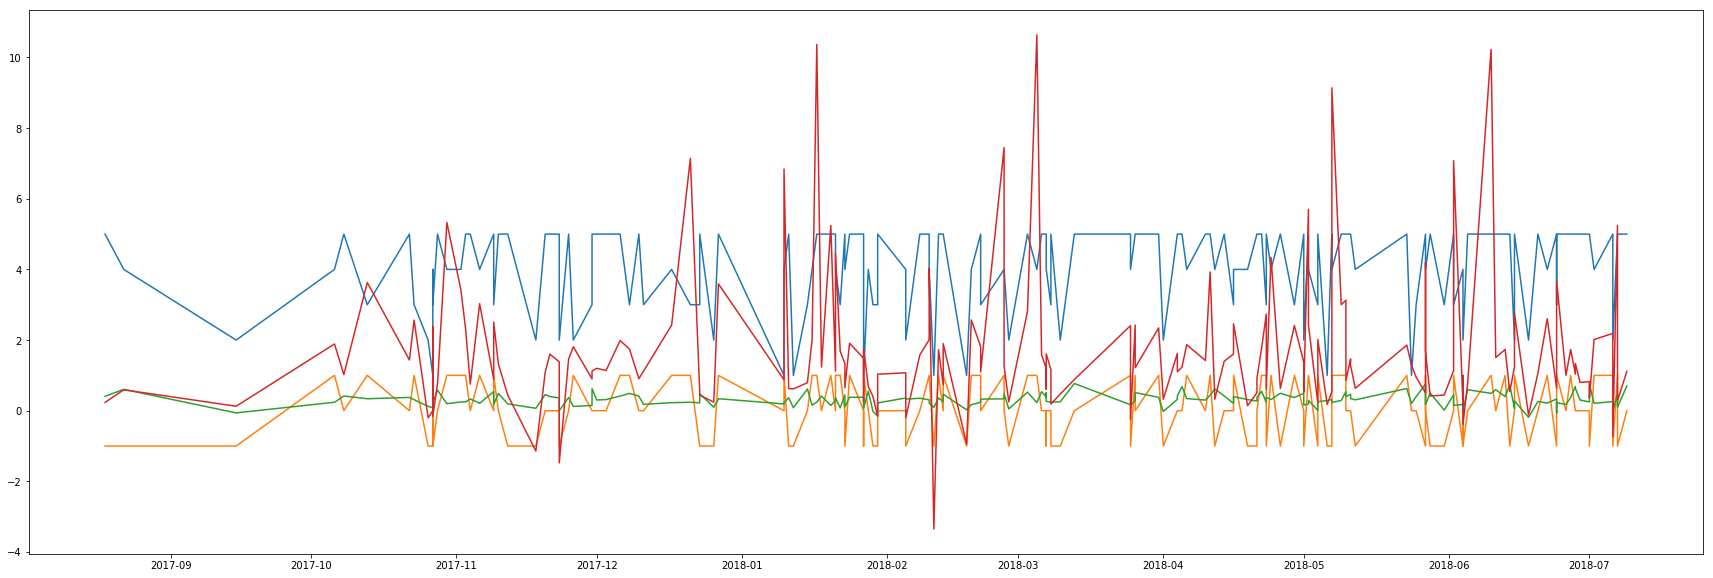

In [96]:
fig, ax = plt.subplots(figsize = (30,10))
sort_by_nbcsent_descending_2 = sort_by_nbcsent_descending.sort_values("Date",ascending=True)

plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['Rating'])
plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['label'])
plt.plot(sort_by_nbcsent_descending_2['Date'],sort_by_nbcsent_descending_2['Sentiment'])
plt.plot(sort_by_nbcsent_descending_2['Date'],.08*sort_by_nbcsent_descending_2['NBC_sentiment'])


sort_by_nbcsent_descending_2.head()